In [32]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import (Vectorizer,SlidingEstimator,
                          cross_val_multiscore, LinearModel, 
                          get_coef)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import itertools
from sklearn.svm import SVC 

In [2]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [3]:
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)

In [4]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [6]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [7]:
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch

In [8]:
epoch

<EpochsFIF  |   5424 events (all good), -0.199219 - 0.5 sec, baseline [-0.199219, 0], ~961.2 MB, data loaded,
 'congruent': 320
 'correct': 231
 'f_baby': 68
 'f_bell': 48
 'f_bird': 48
 'f_burp': 28
 'f_dog': 64
 'f_drum': 60
 'f_knock': 56
 'f_laugh': 96
 'f_phone': 84
 'f_train': 56
 'f_water': 32
 'flanker_stim_1': 100
 'flanker_stim_10': 80
 'flanker_stim_11': 80
 'flanker_stim_12': 60
 'flanker_stim_2': 100
 'flanker_stim_3': 100
 'flanker_stim_4': 61
 'flanker_stim_5': 60
 'flanker_stim_6': 60
 'flanker_stim_7': 100
 'flanker_stim_8': 100
 'flanker_stim_9': 120
 'incongruent': 320
 'incorrect': 37
 'left_button': 334
 'right_button': 342
 't_baby': 60
 't_bell': 50
 't_bird': 50
 't_burp': 60
 't_dog': 60
 't_drum': 50
 't_knock': 60
 't_laugh': 70
 't_phone': 60
 't_train': 70
 't_water': 50
 'target_stim_13': 59
 'target_stim_14': 60
 'target_stim_15': 100
 'target_stim_16': 80
 'target_stim_17': 80
 'target_stim_18': 80
 'target_stim_19': 100
 'target_stim_20': 100
 'target_s

In [9]:
epochWnewStim = update_stim_code(epoch)
epochWnewStim .events.shape

(5424, 3)

In [10]:
events = epochWnewStim.events[:,-1]
event_ids = epochWnewStim.event_id

In [11]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
    
    
}

In [12]:
events = epochWnewStim.events
events_new = []
temp = []
combo = []


for event in events:
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVNN" :
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 100
            elif stim_combinations[combo_tuple] == "AANN":
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 200       
            combo_tuple = []
                
        
        for p in temp:
            if p[-1] == 100 or p[-1] == 200:
                events_new.append(p)
#             if p[-1] >=1 and p[-1] <=24:
#                 events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)
events_new

[array([27806,     0,   100]),
 array([27931,     0,   100]),
 array([28060,     0,   100]),
 array([28521,     0,   100]),
 array([28646,     0,   100]),
 array([28775,     0,   100]),
 array([29292,     0,   100]),
 array([29417,     0,   100]),
 array([29546,     0,   100]),
 array([29826,     0,   100]),
 array([29951,     0,   100]),
 array([30080,     0,   100]),
 array([30752,     0,   100]),
 array([30876,     0,   100]),
 array([31006,     0,   100]),
 array([31406,     0,   100]),
 array([31531,     0,   100]),
 array([31660,     0,   100]),
 array([31940,     0,   100]),
 array([32065,     0,   100]),
 array([32194,     0,   100]),
 array([32646,     0,   100]),
 array([32771,     0,   100]),
 array([32900,     0,   100]),
 array([33383,     0,   100]),
 array([33508,     0,   100]),
 array([33637,     0,   100]),
 array([35463,     0,   100]),
 array([35587,     0,   100]),
 array([35717,     0,   100]),
 array([36328,     0,   100]),
 array([36453,     0,   100]),
 array([

In [13]:
test = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [14]:
type(test)

mne.epochs.EpochsFIF

In [15]:
epochWnewStim.get_data().shape

(5424, 129, 180)

In [16]:
type(epochWnewStim)

mne.epochs.EpochsFIF

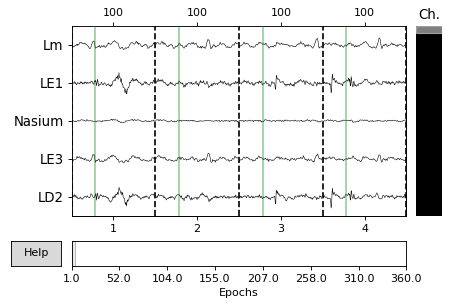

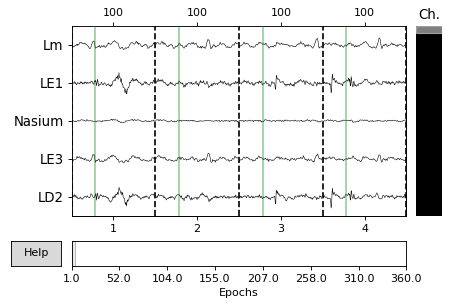

In [16]:
test.plot(n_channels=5,n_epochs=4)

In [17]:
test.get_data().shape

(360, 129, 180)

In [18]:
from sklearn.cross_validation import train_test_split
features_data = test.get_data()
target_V_vs_A = test.events[:,-1]

print("shape of data",features_data.shape)
print("shape of target array",target_V_vs_A.shape)




shape of data (360, 129, 180)
shape of target array (360,)


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    (LogisticRegression(C=1)))

cv = StratifiedKFold(n_splits = 10, shuffle=True)
#y_preds = np.empty(len(target_V_vs_A))
score = []
# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

#i = 0
for train,test in cv.split(features_data,target_V_vs_A):
    X_train = features_data[train] 
    #print("shape of training features(data):",X_train.shape)
    y_train = target_V_vs_A[train] 
    #print("shape of training target:",y_train.shape)
    X_test = features_data[test] 
    #print("shape of testing data:",X_test.shape)
    y_test = target_V_vs_A[test]
    #print("shape of testing target:",y_test.shape)
    
    clf.fit(X_train,y_train)
    #print("shape of 2D data",Vectorizer().fit_transform(X_train).shape)
    #probability for each class on sample
    #proba = clf.predict_proba(X_test)
    #print(proba)
    
    #confidence score per sample where >0 means self.classes[1] will be predicted
    #print(clf.decision_function(X_test))
    #array classes(binary event_id)
    #print(clf.classes_)
    y_preds = clf.predict(X_test)
    y_preds = np.array(y_preds)
    threshold,visual,audio = 100,0,1
    binary_y_preds = np.where(y_preds > threshold, audio,visual)
    #print(binary_y_preds)
    #print(y_preds)
    y_testNP = np.array(y_test)
    #threshold,visual,audio = 100,0,1
    binary_y_test = np.where(y_testNP > threshold, audio,visual)
    #print(binary_y_test)
    
    #print(set(y_test))
#     fpr,tpr,threshold = metrics.roc_curve(y_test,binary_y_preds)
#     tprs.append(interp(mean_fpr,fpr,tpr))
#     tprs[-1][0] = 0.0
#     roc_auc = metrics.auc(fpr,tpr)
#     aucs.append(roc_auc)
    
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#     i += 1
#     plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#              label='Chance', alpha=.8)

#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std(aucs)
#     plt.plot(mean_fpr, mean_tpr, color='b',
#              label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#              lw=2, alpha=.8)

#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                      label=r'$\pm$ 1 std. dev.')

#     plt.xlim([-0.05, 1.05])
#     plt.ylim([-0.05, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()
    
    score.append(clf.score(X_test,y_test))
    
    
    




In [21]:
print("mean classification score", np.mean(score))

mean classification score 0.7638888888888888


In [22]:
binaryEpoch = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [23]:
type(binaryEpoch)

mne.epochs.EpochsFIF

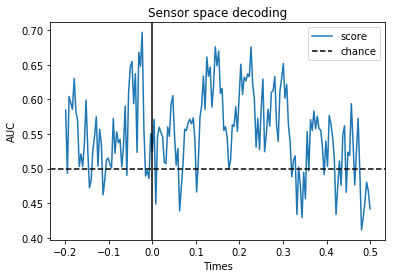

In [24]:
#decoding over time. We are using the last dimension in
#features_data (n_epochs x n_channels x n_times) to fit
#Linear model in each time instance and evaluate performance 
#on same instance for new epochs
clf2 = make_pipeline(StandardScaler(),LinearModel(LogisticRegression(C=1)))
time_decod = SlidingEstimator(clf2,n_jobs=1,scoring='roc_auc')
scores = cross_val_multiscore(time_decod,features_data,target_V_vs_A, cv =5, n_jobs=1)
scores = np.mean(scores, axis=0)
# Plot
fig, ax = plt.subplots()
ax.plot(binaryEpoch.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

In [27]:
time_decod.fit(features_data,target_V_vs_A)
patterns = get_coef(time_decod, 'patterns_', inverse_transform=False)
patterns.shape

(129, 180)

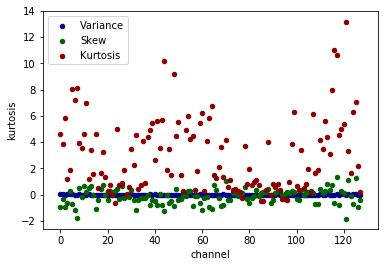

In [107]:
import scipy
arr = [] 
for i in range(0,128):
    temp = []
    var = np.mean(patterns[i])
    skew = scipy.stats.skew(patterns[i])
    kurtosis = scipy.stats.kurtosis(patterns[i])
    temp.append(i)
    temp.append(var)
    temp.append(skew)
    temp.append(kurtosis)
    arr.append(temp)

w = np.array(arr)   
df = pd.DataFrame(w)  
#df
df.columns = ['channel','variance','skew','kurtosis']
ax = df.plot.scatter(x='channel',y='variance',color='DarkBlue',label='Variance')
df.plot.scatter(x='channel',y='skew',color='DarkGreen',label="Skew",ax=ax)
df.plot.scatter(x='channel',y='kurtosis',color="DarkRed",label="Kurtosis",ax=ax)


In [57]:
import scipy
var = np.mean(patterns[0])
skew = scipy.stats.skew(patterns[0])
kurtosis = scipy.stats.kurtosis(patterns[0])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ccc99d668>]],
      dtype=object)

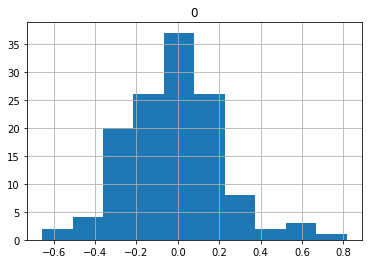

In [493]:
hist = df.hist(column=0)
hist

In [178]:
aaa = Vectorizer().fit_transform(features_data)
aaa.shape


(360, 23220)

In [212]:
df = pd.DataFrame(aaa)

In [213]:
df

,0,1,2,3,4,5,6,7,8,9,...,23210,23211,23212,23213,23214,23215,23216,23217,23218,23219
0,-3.921823e-06,-5.571442e-06,-7.366096e-06,-6.524563e-06,-4.005347e-06,-3.862769e-06,-4.859965e-06,-2.718158e-06,-1.742042e-06,-1.764748e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
1,4.585151e-07,1.334955e-06,1.721369e-06,5.151453e-06,5.680569e-06,5.037848e-06,5.773264e-06,4.190741e-06,2.187261e-06,1.780399e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.445867e-06,-3.173985e-06,-2.885827e-06,-3.581341e-06,-1.680603e-06,-1.934519e-06,-4.541460e-07,-5.035362e-07,4.782355e-07,2.201315e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.445486e-06,-2.589277e-06,-1.189872e-06,-3.303565e-07,5.270368e-07,2.938219e-06,3.698142e-06,3.139596e-06,2.568221e-06,2.410926e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
4,2.077913e-06,-4.561307e-06,-8.878198e-06,-7.208122e-06,-2.337705e-06,-4.857510e-07,9.799401e-07,-1.008280e-06,3.965988e-07,2.658183e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-6.146129e-06,-9.847182e-06,-6.794071e-06,-4.943444e-06,-4.647918e-06,-3.284984e-06,-2.845580e-06,-3.298798e-06,-3.530485e-06,-7.771520e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.716986e-06,3.479391e-06,5.858217e-06,3.656822e-06,3.723697e-06,5.513758e-06,4.253008e-07,-6.206208e-07,-5.964056e-07,-3.299895e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
7,-1.290905e-06,-2.114264e-06,2.794255e-07,2.869302e-06,1.859287e-06,-1.398569e-06,-2.871440e-06,-2.927482e-06,-1.053195e-06,4.657122e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.998460e-06,4.963545e-06,3.714679e-06,2.574560e-06,2.197050e-06,1.708264e-06,-3.167101e-07,1.152561e-06,1.841309e-06,-8.437510e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-5.850758e-06,-4.454986e-06,7.864037e-07,1.603537e-06,1.618401e-07,-1.447479e-06,-1.225500e-06,-4.779112e-07,-2.383629e-06,-4.583182e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0


In [181]:
clf.classes_

array([100, 200])

In [182]:
print(metrics.r2_score(target_test,y_pred))

-0.24401913875598047


array([-4.1920613 , -4.77514058, -0.49106324, -0.22338122,  0.38171083,
        1.74602437, -2.54455606, -2.08286078, -2.95095634, -4.26044356,
       -4.0761867 ,  0.43578667, -2.23397378, -3.57802828, -4.00813011,
       -1.94200906, -3.12121567, -2.13596743,  0.8847367 , -3.21826793,
       -3.13581339, -6.95525329, -5.96633699, -2.35855757,  0.85819578,
       -4.3996523 , -4.3480659 ,  0.63356524, -3.29634454,  3.07940347,
       -0.75305579, -3.27642697, -2.89811734, -1.02155945, -0.8655743 ,
       -0.51790452, -5.10860724, -2.04640956,  1.65945086, -0.72419167,
       -3.39436976, -1.30994811,  0.77474607, -3.85220964,  1.95538628,
       -4.21256811, -7.22996304, -3.43662088, -0.05139956,  1.34315264,
       -3.78605912, -3.88440506, -3.42619506, -0.13859775, -4.69572278,
        1.41365962,  3.00351893, -3.52699453, -0.13780543,  0.87812066,
       -0.9545848 ,  2.67623701, -3.18021571, -7.13119845, -1.43287455,
       -2.62933268, -5.52677051, -2.46194502, -4.69322439, -0.02